***Савенкова Марина, гр. 932226***




#Задание

**Бинарный Классификатор** (вариант чётный)

Оценка вероятности, того, что клиент откроет банковский депозит в результате маркетинговой акции:  https://archive.ics.uci.edu/ml/datasets/Bank+Marketing Класс: атрибут 21 - y - has the client subscribed a term deposit? (binary: 'yes', 'no').

1.	Выполнить загрузку и предварительную обработку данных из наборов.
2.	Разделить каждую выборку на обучающую, тестовую и валидационную.
3.	Произвести обучение набора нейросетевых архитектур, отличающихся разным набором параметров: число слоёв, количество нейронов в слоях, функции активации в слоях, процедур оптимизации: то есть подобрать архитектуры нейронных сетей, которые с одной стороны позволяют получить модели с лучшими метриками качества работы, с другой стороны не являются избыточными и не переобученными.
4.	Вычислить следующие метрики работы:
Для бинарного классификатора: Recall, Precision, Weighted Accuracy, AUC для всех исследованных моделей.


#Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import missingno as msno

In [4]:
import sklearn as skn

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc, roc_curve
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix

In [5]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import metrics

In [6]:
from google.colab import files
from google.colab import drive

In [7]:
# подключение диска

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = "/content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/"

#Функции

In [9]:
# функция для визуализации процесса обучения

def history_visualization(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss', color=clr_violet)
  plt.plot(epochs, val_loss, 'r', label='Validation loss',color=clr_orange)
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.legend()
  plt.show()

In [10]:
# функция для вывода метрик

def print_scores(scores):
  print('Accuracy: ', scores[1])
  print('AUC: ', scores[2])
  print('Precision: ', scores[3])
  print('Recall: ', scores[4])
  print('Weighted Accuracy: ', scores[5])

In [11]:
# функция для построения графика ROC-кривой

def draw_roc_curve(model, X_test, y_test):
  y_pred_keras = model.predict(X_test).ravel()
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--', linewidth=.8, color = '#000')
  plt.plot([0, 0], [0, 1], linewidth=.8, color = clr_orange)
  plt.plot([0, 1], [1, 1], linewidth=.8, color = clr_orange)

  plt.plot(
      fpr_keras,
      tpr_keras,
      label='Binary Classifier (area = {:.3f})'.format(auc_keras),
      color = clr_violet,
      linewidth=1
    )

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')


  plt.show()

In [12]:
# матрица спутанности

def conf_matrix(model, X_test, y_test, palette):

  predicted = model.predict(X_test)
  predicted = tf.squeeze(predicted)
  predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])

  cf_matrix = confusion_matrix(y_test, predicted)

  print(cf_matrix)

  ax = sns.heatmap(cf_matrix, annot=True, cmap=palette)

  ax.set_title('Confusion Matrix\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  plt.show()

#Описание набора данных

Данные связаны с кампаниями прямого маркетинга (телефонными звонками) португальского банковского учреждения. Цель классификации состоит в том, чтобы предсказать, подпишется ли клиент на срочный депозит (переменная y).

Маркетинговые кампании были основаны на телефонных звонках. Часто требовалось более одного контакта с одним и тем же клиентом, чтобы получить доступ к тому, будет ли продукт (банковский срочный депозит) подписан ("да") или нет ("нет").

Существует четыре набора данных:

1) bank-additional-full.csv со всеми примерами (41188) и 20 входными данными, упорядоченными по дате (с мая 2008 по ноябрь 2010), очень близко к данным, проанализированным в [Moro et al., 2014]

2) bank-additional.csv  с 10% примеров (4119), выбранных случайным образом из 1), и 20 входными данными.

3) bank-full.csv со всеми примерами и 17 входными данными, упорядоченный по дате (более старая версия этого набора данных с меньшим количеством входных данных).

4) bank.csv с 10% примеров и 17 входными данными, случайным образом выбранными из 3 (более старая версия этого набора данных с меньшим количеством входных данных).

Самые маленькие наборы данных предоставляются для тестирования более требовательных к вычислениям алгоритмов машинного обучения (например, SVM).

Цель классификации состоит в том, чтобы предсказать, подпишется ли клиент (да/нет) на срочный депозит (переменная y).

В данной работе был использован датасет bank-additional.csv. В наборе данных содержатся следующие признаки:

Данные клиента банка

  - **age** (возраст)
  - **job** (работа) - тип работы; категориальный
  - **marital** (семейное положение) - статус семейного положения; категориальный
  - **education** (образование) - тип образования; категориальный
  - **default** (дефолт) - есть ли кредит в состоянии дефолта, то есть кредит, по которому заемщик не исполняет или не в состоянии исполнить свои кредитные обязательства; категориальный
  - **housing** (жильё) - есть ли у клиента жилищный кредит; категориальный
  - **loan** (кредит) - есть ли у клиента личный заём; категориальный




Данные, связанные с последним контактом текущей кампании

  - **contact** (контакт) - тип контактного общения; категориальный
  - **month** (месяц) -  месяц последнего контакта в году; категориальный
  - **day_of_week** (день недели) - последний контактный день недели; категориальный
  - **duration** - продолжительность последнего контакта в секундах; числовой.
  Примечание: этот атрибут сильно влияет на целевой результат (например, если длительность=0, то y='no'). Тем не менее, продолжительность неизвестна до выполнения вызова. Кроме того, после окончания вызова y, очевидно, известен. Таким образом, эти входные данные следует включать только для целей сравнения и от них следует отказаться, если целью является создание реалистичной прогностической модели.

Другие признаки

  - **campaign** (кампания) - количество контактов, выполненных в ходе этой кампании и для данного клиента; числовое значение, включает последний контакт
  - **pdays** - количество дней, прошедших после того, как с клиентом в последний раз связывались в рамках предыдущей кампании; числовое значение, 999 означает, что ранее с клиентом не связывались
  - **previous** - количество контактов, выполненных до этой кампании и для данного клиента; числовое значение
  - **poutcome**: результат предыдущей маркетинговой кампании; категориальный

Атрибуты социального и экономического контекста

  - **emp.var.rate** - коэффициент вариации занятости - квартальный показатель; числовой
  - **cons.price.idx** - индекс потребительских цен - месячный показатель; числовой
  - **cons.conf.idx** - индекс потребительского доверия - ежемесячный показатель; числовой
  - **euribor3m** - ставка euribor за 3 месяца - ежедневный индикатор; числовой
  - **nr.employed** - количество сотрудников - квартальный показатель; числовой


Целевая переменная

  - **y** - оформил ли клиент срочный депозит; двоичный код: "да", "нет"


#Загрузка набора данных

In [13]:
bank = pd.read_csv(path + 'bank-additional-full.csv', sep=';')

bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


#Анализ и предварительная обработка данных

In [14]:
# настройка параметров отображения графиков
#plt.rcParams.update({'axes.facecolor':'#f5f5f5'})
plt.rcParams['axes.facecolor'] = '#f5f5f5'

# цвета
clr_violet = "#85206a"
clr_orange = "#f78310"

palette = 'inferno'

##Проверка пропущенных значений

<Axes: >

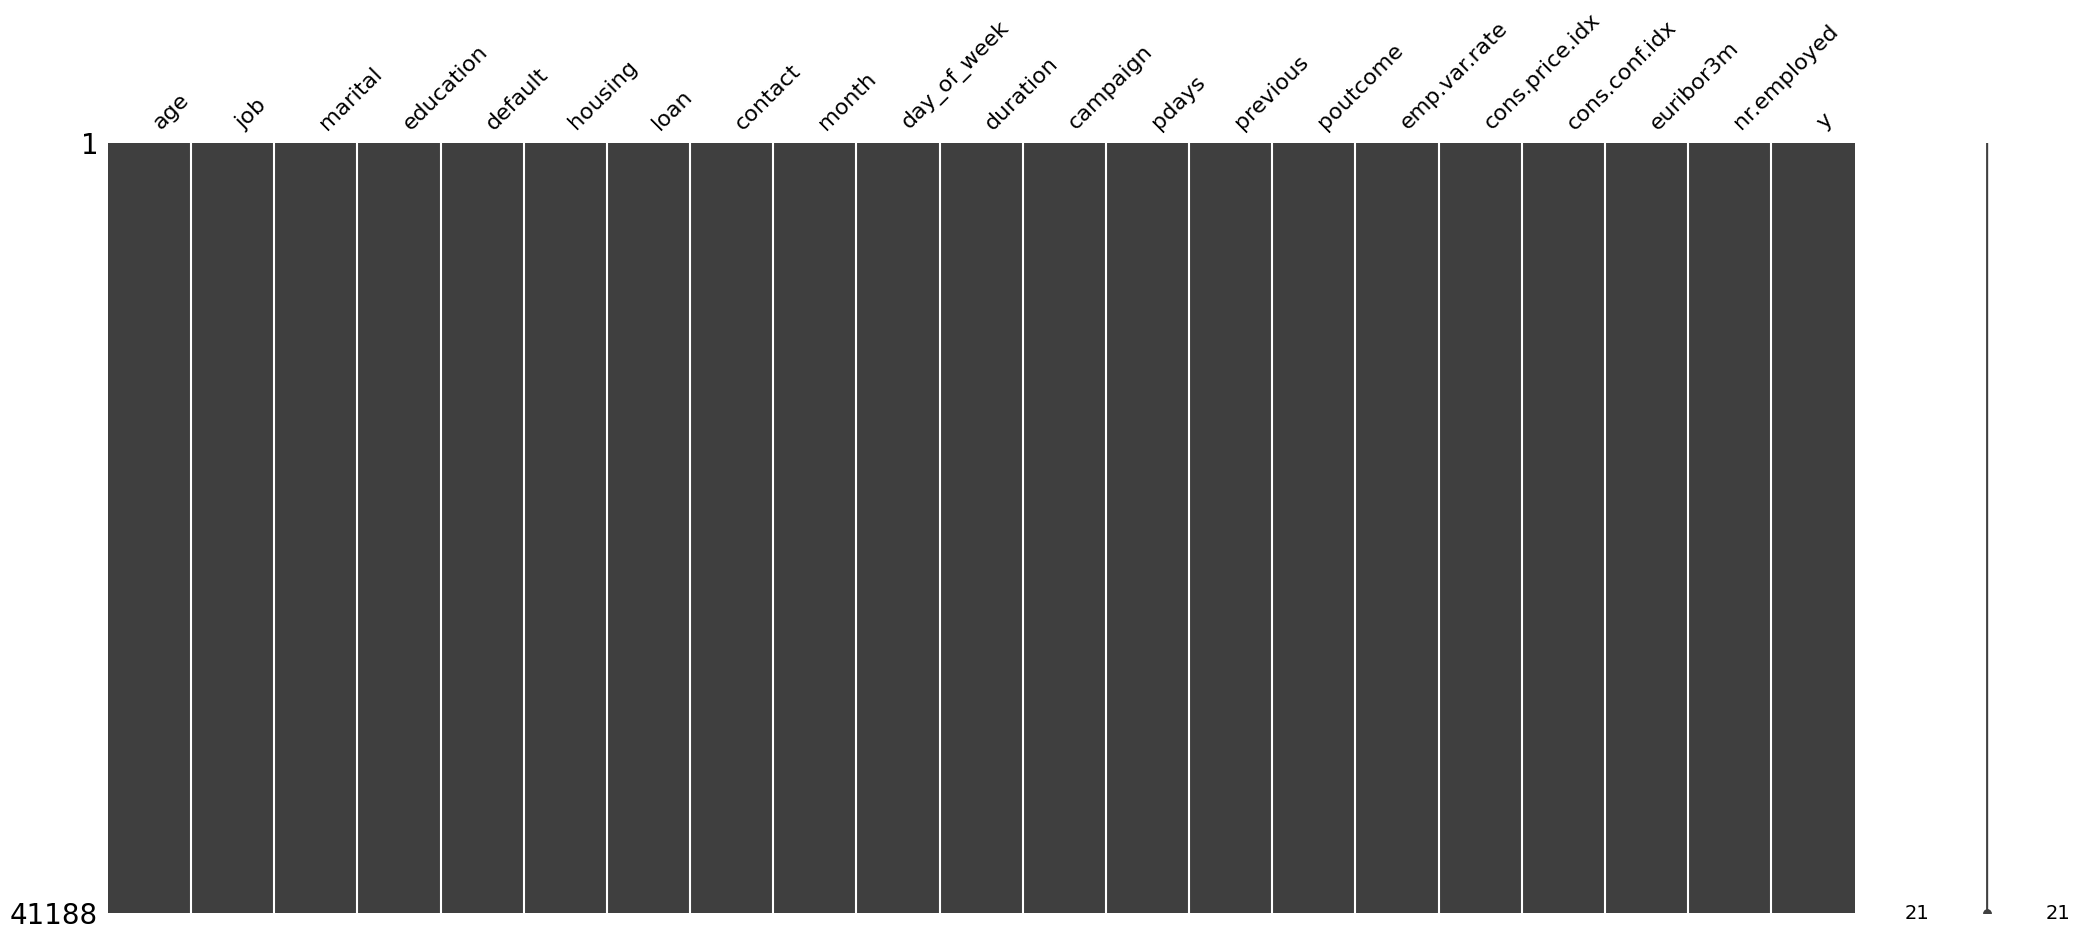

In [15]:
msno.matrix(bank)

Как видно из графика, пропущенные значения в датасете отсутствуют.

##Типы переменных и кодирование признаков

Выведем информацию о фрейме данных.

In [16]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Как было сказано выше, в нашем датасете содержатся категориальные переменные. Выведем уникальные значения признаков типа object.

In [17]:
colnames = list(bank.columns)

for col in colnames:
  if (bank.dtypes[col] == 'object'):
    print(col + ': ', bank[col].unique())

job:  ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital:  ['married' 'single' 'divorced' 'unknown']
education:  ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default:  ['no' 'unknown' 'yes']
housing:  ['no' 'yes' 'unknown']
loan:  ['no' 'yes' 'unknown']
contact:  ['telephone' 'cellular']
month:  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week:  ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome:  ['nonexistent' 'failure' 'success']
y:  ['no' 'yes']


Выполним кодирование категориальных переменных.

In [18]:
le = preprocessing.LabelEncoder()

bank_enc = bank.copy()

for col in colnames:
  if (bank.dtypes[col] == 'object'):
    bank_enc[col]= le.fit_transform(bank_enc[col])

bank_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  int64  
 2   marital         41188 non-null  int64  
 3   education       41188 non-null  int64  
 4   default         41188 non-null  int64  
 5   housing         41188 non-null  int64  
 6   loan            41188 non-null  int64  
 7   contact         41188 non-null  int64  
 8   month           41188 non-null  int64  
 9   day_of_week     41188 non-null  int64  
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  int64  
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [19]:
bank_enc.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


##Проверка датасета на сбалансированность

Выведем количественное соотношение значений целевой переменной.

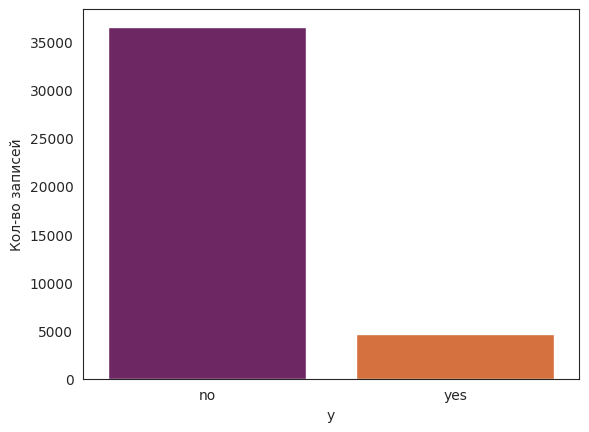

In [20]:
sns.set_style('white')
sns.countplot(x='y',data=bank,palette='inferno')
plt.xlabel('y')
plt.ylabel('Кол-во записей')
plt.show()

Из графика видно, что данные не сбалансированы по категориям.

##Описательная статистика

Выведем описательную статистику.

In [21]:
bank.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


*   Средний возраст клиентов составляет около 40 лет.


*   Среднее значение pdays близко к 999, тогда как значение 999 означает, что с клиентом ранее не связывались.

*   Средняя продолжительность разговора с клиентом составляет 4 минуты, а наибольшая продолжительность разговора - примерно 82 минуты.

Выведем 10 наибольших значений 'duration'.

In [22]:
bank.nlargest(10, ['duration'])['duration']

24091    4918
22192    4199
40537    3785
13820    3643
7727     3631
36043    3509
19632    3422
2313     3366
20996    3322
24043    3284
Name: duration, dtype: int64

Как видим, продолжительность разговора может принимать довольно большие значения.

##Матрица корреляции

Построим матрицу корреляции для признаков.

<Axes: >

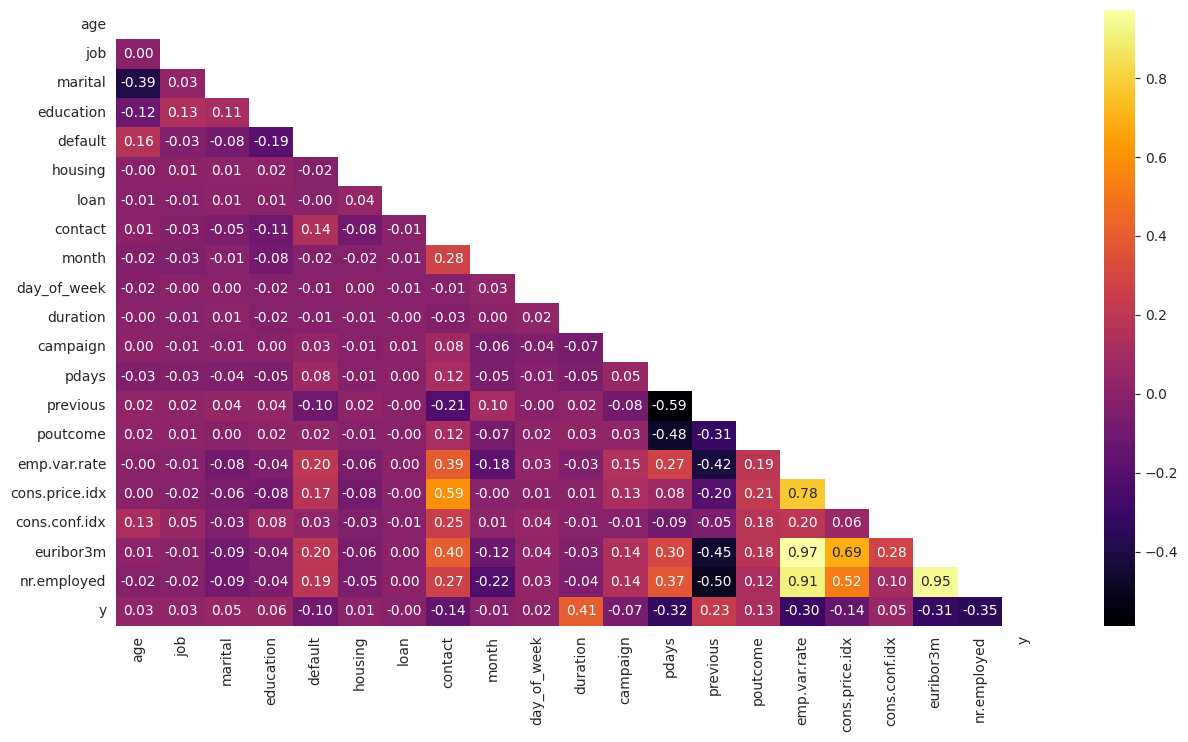

In [23]:
mask = np.triu(np.ones_like(bank_enc.corr()))

plt.figure(figsize=(15,8))
sns.heatmap(bank_enc.corr(),annot=True, fmt='.2f',  cmap='inferno', mask=mask)

##Распределение возраста

Построим возрастное распределение тех, кто оформил кредит, и тех, кто не оформил.

<Figure size 1000x1200 with 0 Axes>

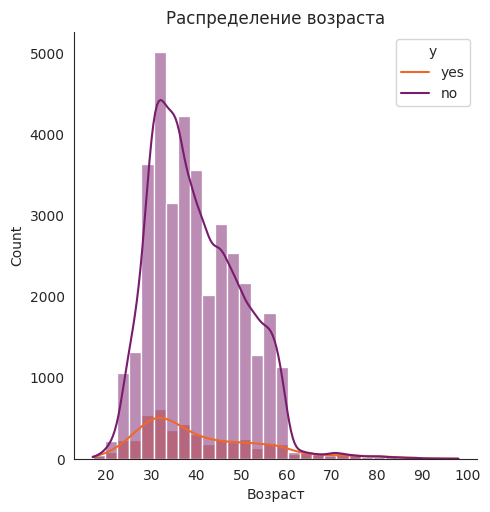

In [24]:
plt.figure(figsize = (10, 12))
g = sns.displot(data=bank, x='age', hue='y', bins=30, kde = True, legend=False, palette='inferno')

plt.title('Распределение возраста')
plt.xlabel('Возраст')

plt.legend(title='y', loc='upper right', labels=['yes', 'no'])
plt.show()

Рассмотрим графики по отдельности.

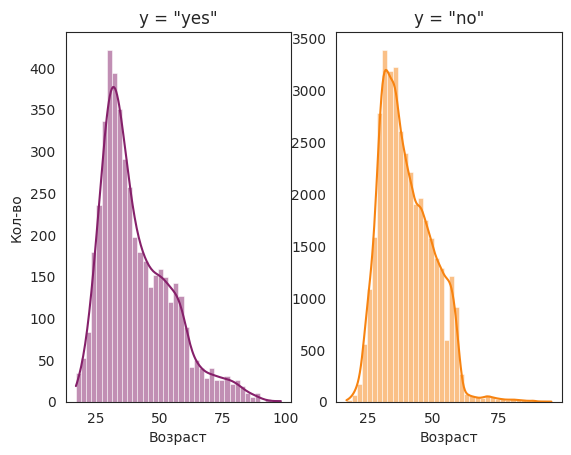

In [25]:
fig, axes = plt.subplots(1, 2)
plt.style.use('default')

sns.set(rc={"figure.figsize":(8, 4)})

sns.histplot(bank.loc[bank['y']=='yes']['age'], bins=40, kde = True,color=clr_violet , ax=axes[0])
axes[0].set_xlabel("Возраст", fontsize = 10)
axes[0].set_ylabel('Кол-во')
axes[0].set_title('y = "yes"')

sns.histplot(bank.loc[bank['y']=='no']['age'], bins=40, kde = True, color=clr_orange, ax=axes[1])
axes[1].set_xlabel("Возраст", fontsize = 10)
axes[1].set_ylabel('')
axes[1].set_title('y = "no"')

plt.show();

Как видим, графики очень похожи. Большинство клиентов, оформивших срочный депозит, находятся в возрасте от 30 до 50 лет, что также соответствует возрасту с наибольшим доходом.

##Зависимость целевой переменной от типа работы

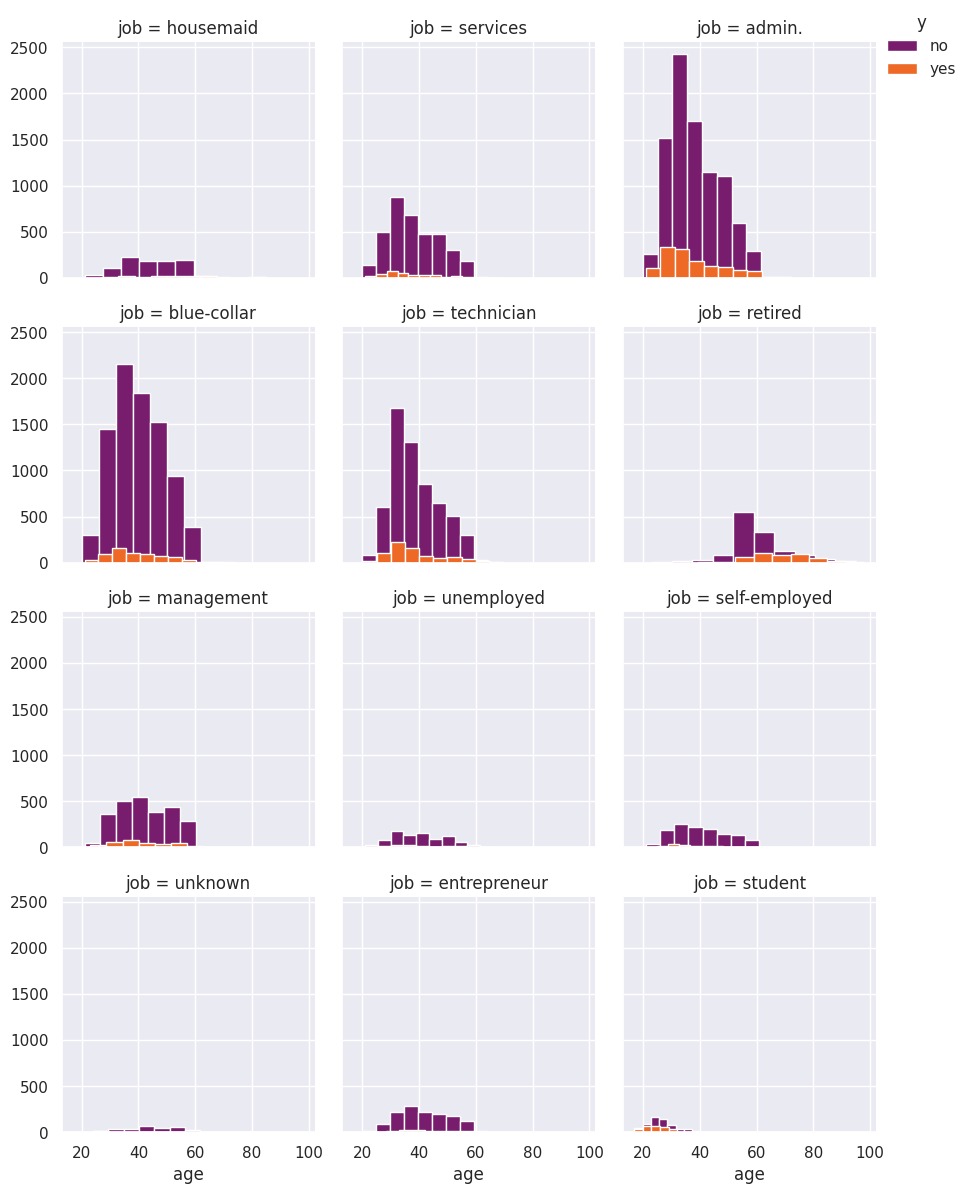

In [26]:
grid_layout = sns.FacetGrid(bank, col='job', hue='y', col_wrap = 3, palette='inferno')
grid_layout.map(plt.hist, 'age')
grid_layout.add_legend(loc='upper right')

plt.show()

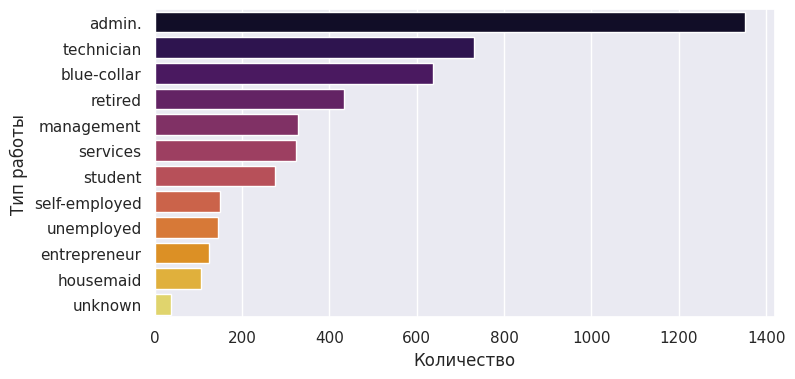

In [27]:
yes_data = bank[bank['y']=='yes']

g = sns.countplot(
    data = yes_data, y = 'job',
    order = yes_data['job'].value_counts().index,
    palette = 'inferno'
  )

g.set_xlabel('Количество')
g.set_ylabel('Тип работы')

plt.show(g);

##Семейное положение

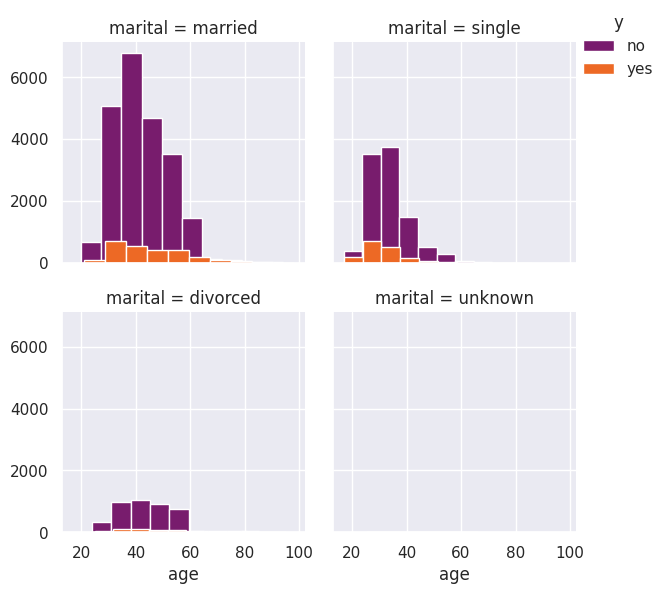

In [28]:
grid_layout = sns.FacetGrid(bank, col = 'marital', hue='y', col_wrap = 2, palette='inferno')
grid_layout.map(plt.hist, 'age')
grid_layout.add_legend(loc='upper right')

Больше супружеских пар оформили срочный депозит.

##Образование

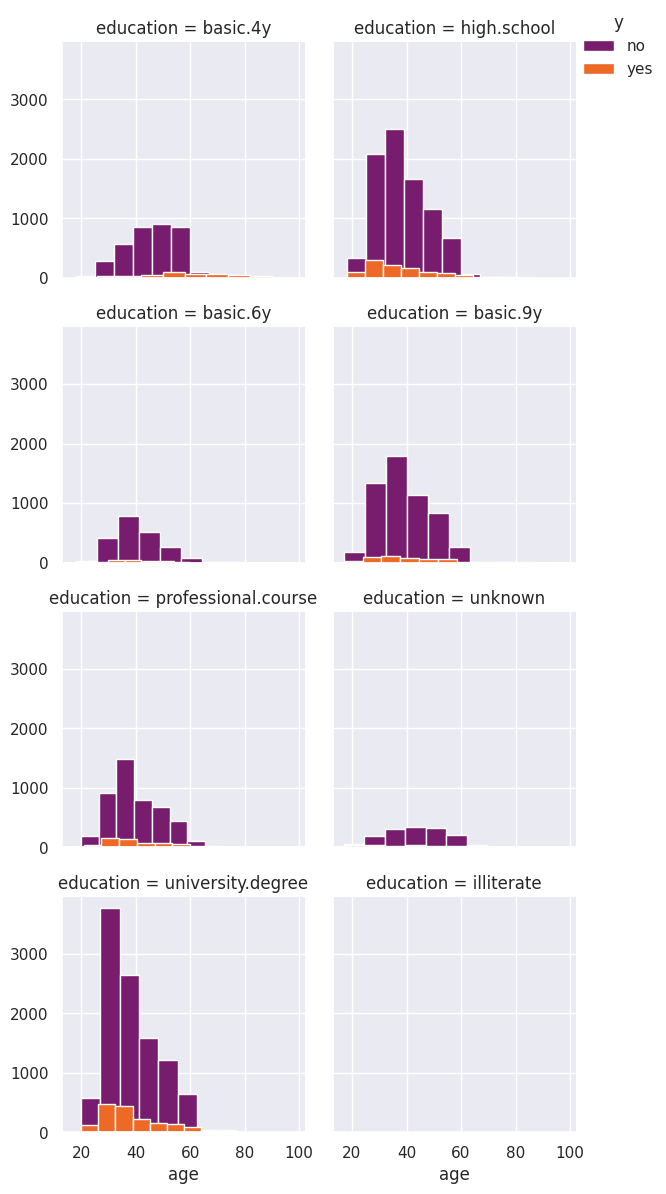

In [29]:
grid_layout = sns.FacetGrid(bank, col = 'education', hue='y', col_wrap = 2, palette='inferno')
grid_layout.map(plt.hist, 'age')
grid_layout.add_legend(loc='upper right')

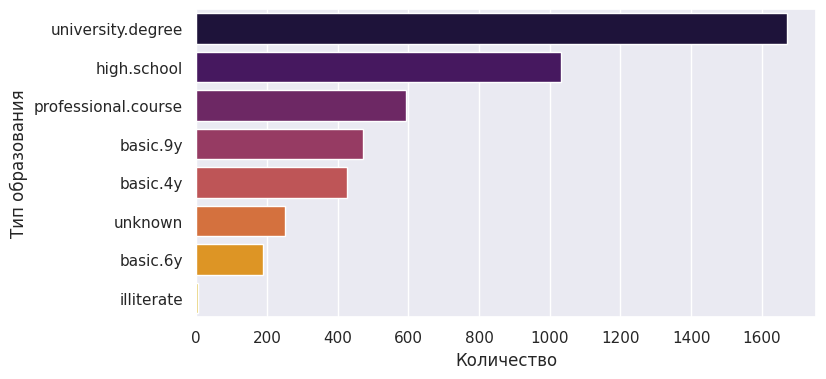

In [30]:
yes_data = bank[bank['y']=='yes']

g = sns.countplot(
    data = yes_data, y = 'education',
    order = yes_data['education'].value_counts().index,
    palette = 'inferno'
  )

g.set_xlabel('Количество')
g.set_ylabel('Тип образования')

plt.show(g);

Графики демонстрируют, что чем выше уровень образования человека, тем в более раннем возрасте он может получить кредит.

##Жилищный кредит

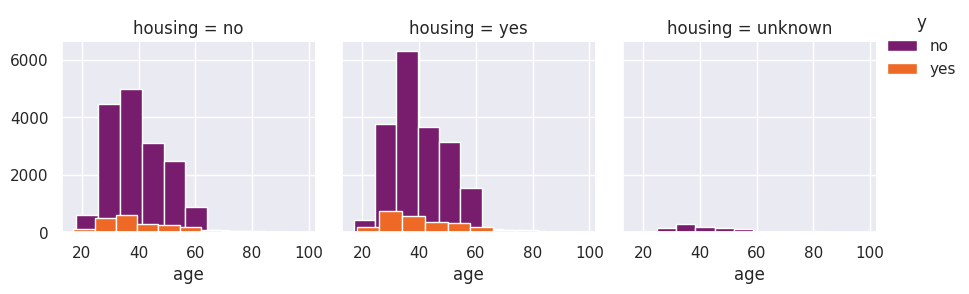

In [31]:
grid_layout = sns.FacetGrid(bank, col = 'housing', hue='y', col_wrap = 3, palette='inferno')
grid_layout.map(plt.hist, 'age')
grid_layout.add_legend(loc='upper right')

Наличие жилищного кредита слабо влияет на взятие кредита.

##Личный заём

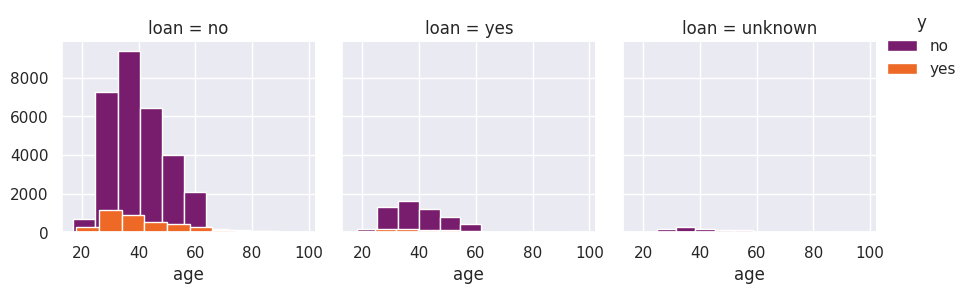

In [32]:
grid_layout = sns.FacetGrid(bank, col = 'loan', hue='y', col_wrap = 3, palette='inferno')
grid_layout.map(plt.hist, 'age')
grid_layout.add_legend(loc='upper right')

Среди не имеющих личный заем вероятность взятия кредита больше.

#Разделение данных на выборки (Undersampling)

In [33]:
df_majority_class = bank_enc[bank_enc['y'] == 0]
df_minority_class = bank_enc[bank_enc['y'] == 1]

In [34]:
df_class_undersample = df_majority_class.sample(len(df_minority_class), random_state=0)

In [35]:
df_balanced = pd.concat([df_class_undersample, df_minority_class], axis=0)

In [36]:
bank_features = df_balanced.drop(columns=['y'])
bank_target = df_balanced['y']

In [37]:
min_max_scaler = MinMaxScaler()
bank_features = min_max_scaler.fit_transform(bank_features)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
  bank_features,
  bank_target,
  train_size=0.7,
  random_state=0,
  stratify=bank_target
)

print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [3248 3248]
Количество строк в y_test по классам: [1392 1392]


In [39]:
X_test, X_val, y_test, y_val = train_test_split(
  X_test, y_test,
  train_size=0.5,
  random_state=0,
  stratify=y_test
)

print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")
print(f"Количество строк в y_val по классам: {np.bincount(y_val)}")

Количество строк в y_test по классам: [696 696]
Количество строк в y_val по классам: [696 696]


##Модель №1



Создадим простую полносвязную сеть с двумя слоями 32 и 1 нейрона. Функция активации первого слоя - relu, второго - sigmoid, поскольку мы решаем задачу бинарной классификации.

In [40]:
binary_classifier_1 = Sequential()

binary_classifier_1.add(Dense(32,activation='relu'))
binary_classifier_1.add(Dense(1,activation='sigmoid'))

###Настройка параметров обучения

В качестве функции потерь устанавливаем бинарную кросс-энтропию, алгоритма оптимизации - Adam.

In [41]:
binary_classifier_1.compile(
  loss = "binary_crossentropy",
  optimizer = "adam",
  metrics = [
      metrics.BinaryAccuracy(),
      metrics.AUC(),
      metrics.Precision(),
      metrics.Recall()
    ],
  weighted_metrics = ['accuracy']
)

In [42]:
early_stop = EarlyStopping(
  monitor = 'val_accuracy',
  patience = 7,
  mode = 'max',
  verbose = 1
)

#checkpoint_filepath = path + 'task1/' + 'BC№1-{epoch:02d}-{val_accuracy:.3f}.hdf5'
checkpoint_filepath_1 = path + 'task1/' + 'BC№1.hdf5'

checkpoint = ModelCheckpoint(
  filepath = checkpoint_filepath_1,
  monitor = 'val_binary_accuracy',
  verbose = 1,
  mode = 'max',
  save_best_only = True
)

callbacks_list = [
    early_stop,
    checkpoint
  ]

###Обучение модели

In [43]:
binary_classifier_1_history = binary_classifier_1.fit(
  X_train,
  y_train,
  batch_size=10,
  validation_data=(X_val,y_val),
  callbacks=callbacks_list,
  epochs=90
)

Epoch 1/90
647/650 [============================>.] - ETA: 0s - loss: 0.5604 - binary_accuracy: 0.7071 - auc: 0.7874 - precision: 0.7159 - recall: 0.6874 - accuracy: 0.7071
Epoch 1: val_binary_accuracy improved from -inf to 0.75862, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task1/BC№1.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


650/650 [==============================] - 5s 6ms/step - loss: 0.5602 - binary_accuracy: 0.7075 - auc: 0.7877 - precision: 0.7162 - recall: 0.6875 - accuracy: 0.7075 - val_loss: 0.4980 - val_binary_accuracy: 0.7586 - val_auc: 0.8578 - val_precision: 0.7632 - val_recall: 0.7500 - val_accuracy: 0.7586
Epoch 2/90
650/650 [==============================] - ETA: 0s - loss: 0.4563 - binary_accuracy: 0.7886 - auc: 0.8801 - precision: 0.8035 - recall: 0.7642 - accuracy: 0.7886
Epoch 2: val_binary_accuracy improved from 0.75862 to 0.81178, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task1/BC№1.hdf5
650/650 [==============================] - 2s 4ms/step - loss: 0.4563 - binary_accuracy: 0.7886 - auc: 0.8801 - precision: 0.8035 - recall: 0.7642 - accuracy: 0.7886 - val_loss: 0.4309 - val_binary_accuracy: 0.8118 - val_auc: 0.9015 - val_precision: 0.8444 - val_recall: 0.7644 - val_accuracy: 0.8118
Epoch 3/90
633/650 [============================>.] 

###Оценка модели

<ipython-input-9-c5e552899689>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.8, 0.7254901960784313, 0.4549019607843137, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color=clr_violet)
<ipython-input-9-c5e552899689>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss',color=clr_orange)


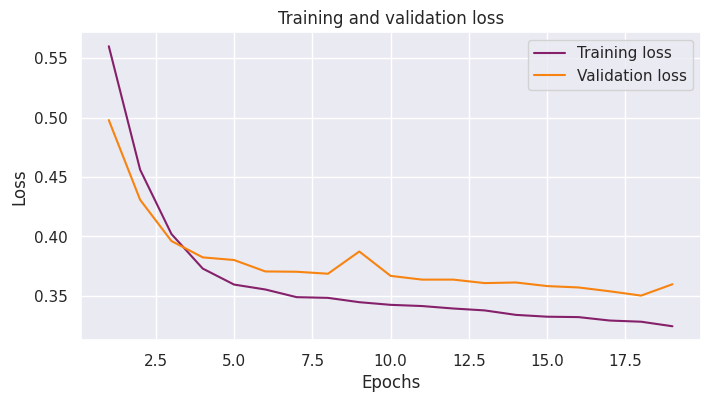

In [44]:
history_visualization(binary_classifier_1_history)

In [45]:
binary_classifier_1_loaded = keras.models.load_model(checkpoint_filepath_1)

In [46]:
loaded_scores_1 = binary_classifier_1_loaded.evaluate(X_test, y_test, verbose=1)
print_scores(loaded_scores_1)

44/44 [==============================] - 0s 2ms/step - loss: 0.3516 - binary_accuracy: 0.8614 - auc: 0.9253 - precision: 0.8440 - recall: 0.8865 - accuracy: 0.8614
Accuracy:  0.8613505959510803
AUC:  0.9253327250480652
Precision:  0.8440492749214172
Recall:  0.8864942789077759
Weighted Accuracy:  0.8613505959510803


44/44 [==============================] - 0s 2ms/step


<ipython-input-11-53c60886be05>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linewidth=.8, color = '#000')


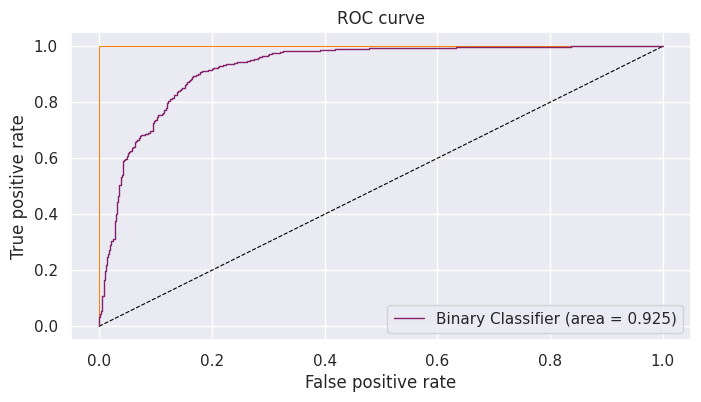

In [47]:
draw_roc_curve(binary_classifier_1_loaded, X_test, y_test)

44/44 [==============================] - 0s 2ms/step
[[582 114]
 [ 79 617]]


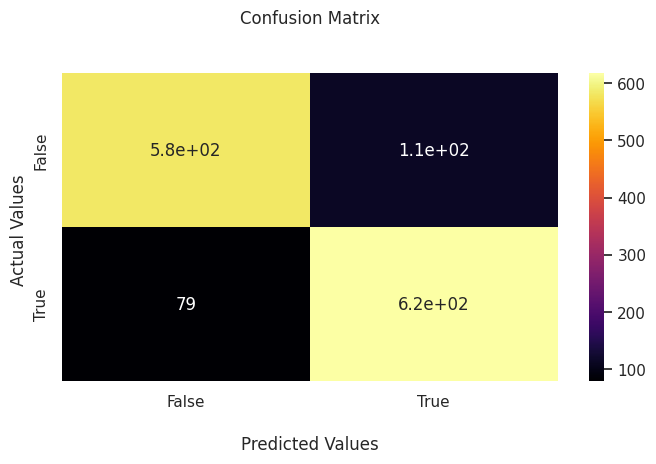

In [48]:
conf_matrix(binary_classifier_1_loaded, X_test, y_test, palette)

##Модель №2



In [49]:
binary_classifier_2 = Sequential()

binary_classifier_2.add(Dense(128,activation='relu'))
binary_classifier_2.add(Dense(64,activation='relu'))
binary_classifier_2.add(Dense(32,activation='relu'))
binary_classifier_2.add(Dense(1,activation='sigmoid'))

###Настройка параметров обучения

In [50]:
binary_classifier_2.compile(
  loss = "binary_crossentropy",
  optimizer = "RMSprop",
  metrics = [
      metrics.BinaryAccuracy(),
      metrics.AUC(),
      metrics.Precision(),
      metrics.Recall()
    ],
  weighted_metrics = ['accuracy']
)

In [51]:
early_stop = EarlyStopping(
  monitor = 'val_accuracy',
  patience = 7,
  mode = 'max',
  verbose = 1
)

#checkpoint_filepath = path + 'task1/' + 'BC№1-{epoch:02d}-{val_accuracy:.3f}.hdf5'
checkpoint_filepath_2 = path + 'task1/' + 'BC№2.hdf5'

checkpoint = ModelCheckpoint(
  filepath = checkpoint_filepath_2,
  monitor = 'val_binary_accuracy',
  verbose = 1,
  mode = 'max',
  save_best_only = True
)

callbacks_list = [
    early_stop,
    checkpoint
  ]

###Обучение модели

In [52]:
binary_classifier_2_history = binary_classifier_2.fit(
  X_train,
  y_train,
  batch_size=10,
  validation_data=(X_val,y_val),
  callbacks=callbacks_list,
  epochs=90
)

Epoch 1/90
636/650 [============================>.] - ETA: 0s - loss: 0.4692 - binary_accuracy: 0.7854 - auc_1: 0.8611 - precision_1: 0.7925 - recall_1: 0.7723 - accuracy: 0.7854
Epoch 1: val_binary_accuracy improved from -inf to 0.84267, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task1/BC№2.hdf5
650/650 [==============================] - 3s 3ms/step - loss: 0.4678 - binary_accuracy: 0.7860 - auc_1: 0.8620 - precision_1: 0.7934 - recall_1: 0.7734 - accuracy: 0.7860 - val_loss: 0.3801 - val_binary_accuracy: 0.8427 - val_auc_1: 0.9164 - val_precision_1: 0.8597 - val_recall_1: 0.8190 - val_accuracy: 0.8427
Epoch 2/90
 47/650 [=>............................] - ETA: 1s - loss: 0.3978 - binary_accuracy: 0.8362 - auc_1: 0.9084 - precision_1: 0.8313 - recall_1: 0.8554 - accuracy: 0.8362

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


643/650 [============================>.] - ETA: 0s - loss: 0.3596 - binary_accuracy: 0.8515 - auc_1: 0.9202 - precision_1: 0.8411 - recall_1: 0.8665 - accuracy: 0.8515
Epoch 2: val_binary_accuracy improved from 0.84267 to 0.86638, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task1/BC№2.hdf5
650/650 [==============================] - 2s 3ms/step - loss: 0.3602 - binary_accuracy: 0.8508 - auc_1: 0.9199 - precision_1: 0.8398 - recall_1: 0.8670 - accuracy: 0.8508 - val_loss: 0.3404 - val_binary_accuracy: 0.8664 - val_auc_1: 0.9232 - val_precision_1: 0.8512 - val_recall_1: 0.8879 - val_accuracy: 0.8664
Epoch 3/90
638/650 [============================>.] - ETA: 0s - loss: 0.3439 - binary_accuracy: 0.8567 - auc_1: 0.9237 - precision_1: 0.8345 - recall_1: 0.8891 - accuracy: 0.8567
Epoch 3: val_binary_accuracy did not improve from 0.86638
650/650 [==============================] - 2s 3ms/step - loss: 0.3446 - binary_accuracy: 0.8562 - auc_1: 0.92

###Оценка модели

<ipython-input-9-c5e552899689>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.8, 0.7254901960784313, 0.4549019607843137, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color=clr_violet)
<ipython-input-9-c5e552899689>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss',color=clr_orange)


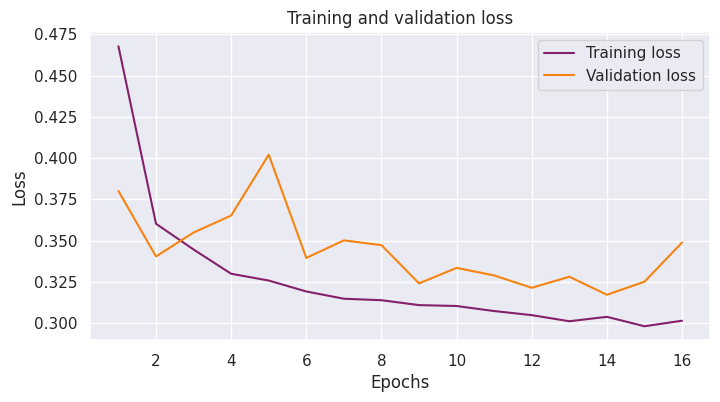

In [53]:
history_visualization(binary_classifier_2_history)

In [54]:
binary_classifier_2_loaded = keras.models.load_model(checkpoint_filepath_2)

In [55]:
loaded_scores_2 = binary_classifier_2_loaded.evaluate(X_test, y_test, verbose=1)
print_scores(loaded_scores_2)

44/44 [==============================] - 0s 2ms/step - loss: 0.3276 - binary_accuracy: 0.8628 - auc_1: 0.9320 - precision_1: 0.8258 - recall_1: 0.9195 - accuracy: 0.8628
Accuracy:  0.8627873659133911
AUC:  0.9320366978645325
Precision:  0.8258064389228821
Recall:  0.9195402264595032
Weighted Accuracy:  0.8627873659133911


44/44 [==============================] - 0s 2ms/step


<ipython-input-11-53c60886be05>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linewidth=.8, color = '#000')


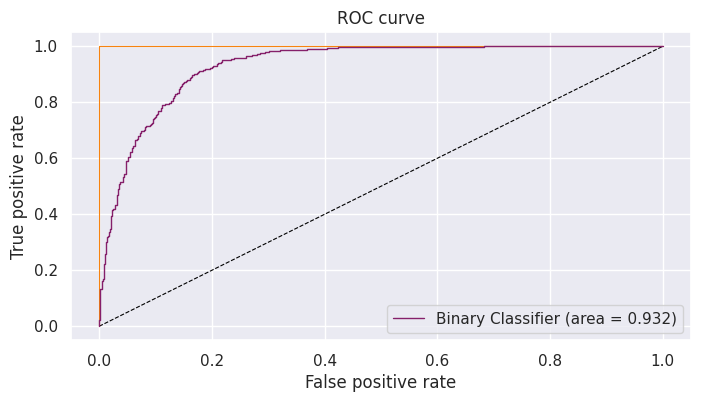

In [56]:
draw_roc_curve(binary_classifier_2_loaded, X_test, y_test)

44/44 [==============================] - 0s 2ms/step
[[561 135]
 [ 56 640]]


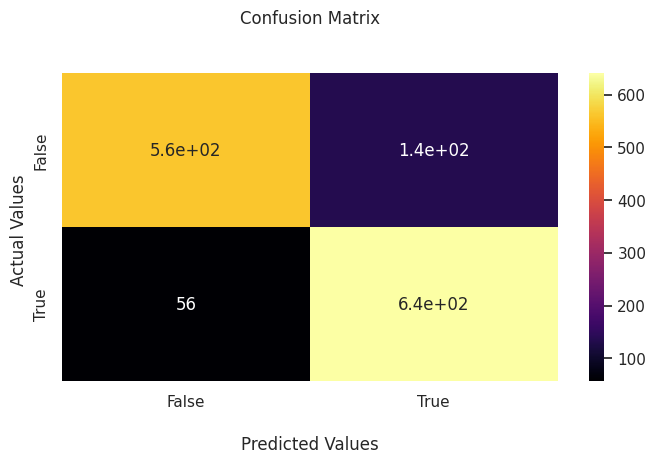

In [57]:
conf_matrix(binary_classifier_2_loaded, X_test, y_test, palette)

##Модель №3



In [58]:
binary_classifier_3 = Sequential()

binary_classifier_3.add(Dense(128,activation='relu'))
binary_classifier_3.add(tf.keras.layers.Dropout(.05))
binary_classifier_3.add(Dense(64,activation='selu'))
binary_classifier_3.add(tf.keras.layers.Dropout(.1))
binary_classifier_3.add(Dense(32,activation='relu'))
binary_classifier_3.add(Dense(1,activation='sigmoid'))

###Настройка параметров обучения

In [59]:
binary_classifier_3.compile(
  loss = "binary_crossentropy",
  optimizer = "adam",
  metrics = [
      metrics.BinaryAccuracy(),
      metrics.AUC(),
      metrics.Precision(),
      metrics.Recall()
    ],
  weighted_metrics = ['accuracy']
)

In [60]:
early_stop = EarlyStopping(
  monitor = 'val_accuracy',
  patience = 7,
  mode = 'max',
  verbose = 1
)

#checkpoint_filepath = path + 'task1/' + 'BC№1-{epoch:02d}-{val_accuracy:.3f}.hdf5'
checkpoint_filepath_3 = path + 'task1/' + 'BC№3.hdf5'

checkpoint = ModelCheckpoint(
  filepath = checkpoint_filepath_3,
  monitor = 'val_binary_accuracy',
  verbose = 1,
  mode = 'max',
  save_best_only = True
)

callbacks_list = [
    early_stop,
    checkpoint
  ]

###Обучение модели

In [61]:
binary_classifier_3_history = binary_classifier_3.fit(
  X_train,
  y_train,
  batch_size=32,
  validation_data=(X_val,y_val),
  callbacks=callbacks_list,
  epochs=90
)

Epoch 1/90
199/203 [============================>.] - ETA: 0s - loss: 0.5173 - binary_accuracy: 0.7525 - auc_2: 0.8243 - precision_2: 0.7647 - recall_2: 0.7297 - accuracy: 0.7525
Epoch 1: val_binary_accuracy improved from -inf to 0.81466, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task1/BC№3.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/203 [==============================] - 3s 9ms/step - loss: 0.5150 - binary_accuracy: 0.7540 - auc_2: 0.8264 - precision_2: 0.7668 - recall_2: 0.7300 - accuracy: 0.7540 - val_loss: 0.4139 - val_binary_accuracy: 0.8147 - val_auc_2: 0.9067 - val_precision_2: 0.8626 - val_recall_2: 0.7486 - val_accuracy: 0.8147
Epoch 2/90
195/203 [===========================>..] - ETA: 0s - loss: 0.3775 - binary_accuracy: 0.8409 - auc_2: 0.9126 - precision_2: 0.8371 - recall_2: 0.8475 - accuracy: 0.8409
Epoch 2: val_binary_accuracy improved from 0.81466 to 0.86207, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task1/BC№3.hdf5
203/203 [==============================] - 1s 5ms/step - loss: 0.3781 - binary_accuracy: 0.8405 - auc_2: 0.9124 - precision_2: 0.8358 - recall_2: 0.8476 - accuracy: 0.8405 - val_loss: 0.3551 - val_binary_accuracy: 0.8621 - val_auc_2: 0.9200 - val_precision_2: 0.8360 - val_recall_2: 0.9009 - val_accuracy: 0.8621
Epoch 3/90
190/203 [==

###Оценка модели

<ipython-input-9-c5e552899689>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.8, 0.7254901960784313, 0.4549019607843137, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color=clr_violet)
<ipython-input-9-c5e552899689>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss',color=clr_orange)


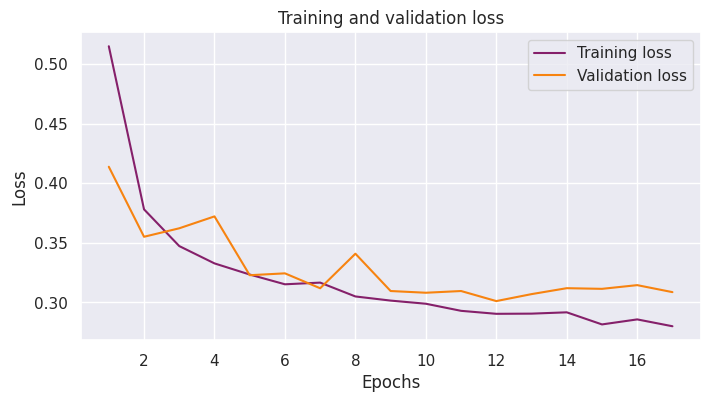

In [62]:
history_visualization(binary_classifier_3_history)

In [63]:
binary_classifier_3_loaded = keras.models.load_model(checkpoint_filepath_3)

In [64]:
loaded_scores_3 = binary_classifier_3_loaded.evaluate(X_test, y_test, verbose=1)
print_scores(loaded_scores_3)

44/44 [==============================] - 0s 2ms/step - loss: 0.3299 - binary_accuracy: 0.8664 - auc_2: 0.9273 - precision_2: 0.8295 - recall_2: 0.9224 - accuracy: 0.8664
Accuracy:  0.8663793206214905
AUC:  0.9272876977920532
Precision:  0.8294573426246643
Recall:  0.9224137663841248
Weighted Accuracy:  0.8663793206214905


44/44 [==============================] - 0s 2ms/step


<ipython-input-11-53c60886be05>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linewidth=.8, color = '#000')


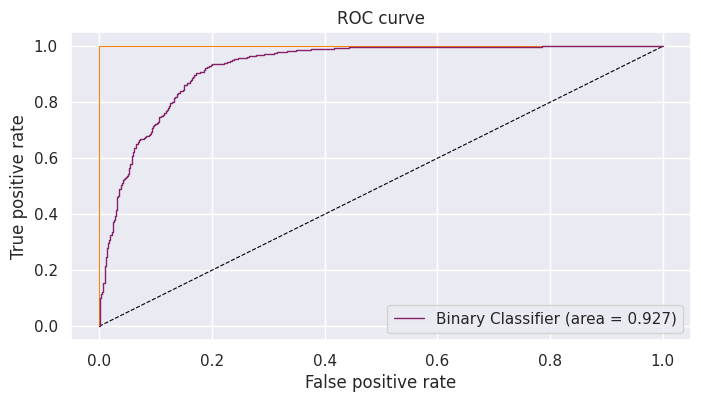

In [65]:
draw_roc_curve(binary_classifier_3_loaded, X_test, y_test)

44/44 [==============================] - 0s 2ms/step
[[564 132]
 [ 54 642]]


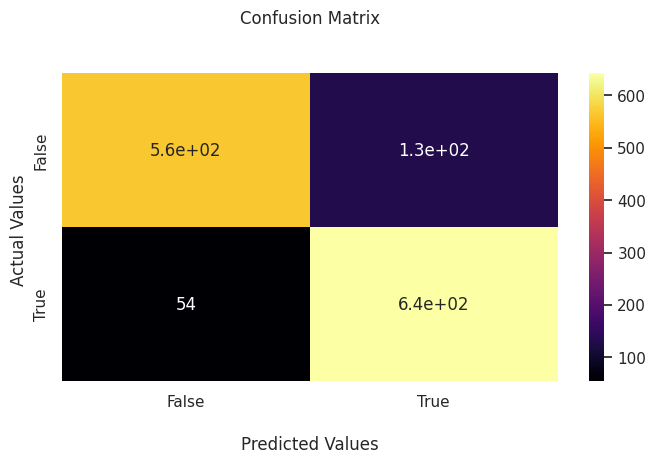

In [66]:
conf_matrix(binary_classifier_3_loaded, X_test, y_test, palette)

##Модель №4



In [67]:
binary_classifier_4 = Sequential()

binary_classifier_4.add(Dense(128,activation='relu'))
binary_classifier_4.add(tf.keras.layers.Dropout(.05))
binary_classifier_4.add(Dense(64,activation='selu'))
binary_classifier_4.add(tf.keras.layers.Dropout(.3))
binary_classifier_4.add(Dense(32,activation='relu'))
binary_classifier_4.add(Dense(1,activation='sigmoid'))

###Настройка параметров обучения

In [68]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

In [69]:
binary_classifier_4.compile(
  loss = "binary_crossentropy",
  optimizer = tf.keras.optimizers.Adam(),
  metrics = [
      metrics.BinaryAccuracy(),
      metrics.AUC(),
      metrics.Precision(),
      metrics.Recall()
    ],
  weighted_metrics = ['accuracy']
)

In [70]:
round(binary_classifier_4.optimizer.lr.numpy(), 5)

0.001

In [71]:
lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [72]:
early_stop = EarlyStopping(
  monitor = 'val_accuracy',
  patience = 10,
  mode = 'max',
  verbose = 1
)

#checkpoint_filepath = path + 'task1/' + 'BC№1-{epoch:02d}-{val_accuracy:.3f}.hdf5'
checkpoint_filepath_4 = path + 'task1/' + 'BC№4.hdf5'

checkpoint = ModelCheckpoint(
  filepath = checkpoint_filepath_4,
  monitor = 'val_binary_accuracy',
  verbose = 1,
  mode = 'max',
  save_best_only = True
)


callbacks_list = [
    early_stop,
    checkpoint,
    lr_cb
  ]

###Обучение модели

In [73]:
binary_classifier_4_history = binary_classifier_4.fit(
  X_train,
  y_train,
  batch_size=32,
  validation_data=(X_val,y_val),
  callbacks=callbacks_list,
  epochs=90
)

Epoch 1/90
194/203 [===========================>..] - ETA: 0s - loss: 0.5327 - binary_accuracy: 0.7374 - auc_3: 0.8081 - precision_3: 0.7599 - recall_3: 0.6948 - accuracy: 0.7374
Epoch 1: val_binary_accuracy improved from -inf to 0.82687, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task1/BC№4.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/203 [==============================] - 4s 8ms/step - loss: 0.5286 - binary_accuracy: 0.7408 - auc_3: 0.8120 - precision_3: 0.7619 - recall_3: 0.7004 - accuracy: 0.7408 - val_loss: 0.4216 - val_binary_accuracy: 0.8269 - val_auc_3: 0.9013 - val_precision_3: 0.8218 - val_recall_3: 0.8348 - val_accuracy: 0.8269 - lr: 0.0010
Epoch 2/90
203/203 [==============================] - ETA: 0s - loss: 0.3852 - binary_accuracy: 0.8371 - auc_3: 0.9091 - precision_3: 0.8359 - recall_3: 0.8390 - accuracy: 0.8371
Epoch 2: val_binary_accuracy improved from 0.82687 to 0.83693, saving model to /content/drive/MyDrive/STUDY/магистратура курс 2/Глубинное обучение/Задание 1/task1/BC№4.hdf5
203/203 [==============================] - 1s 5ms/step - loss: 0.3852 - binary_accuracy: 0.8371 - auc_3: 0.9091 - precision_3: 0.8359 - recall_3: 0.8390 - accuracy: 0.8371 - val_loss: 0.3677 - val_binary_accuracy: 0.8369 - val_auc_3: 0.9231 - val_precision_3: 0.8670 - val_recall_3: 0.7960 - val_accuracy: 0.8369 - lr: 0.0

###Оценка модели

<ipython-input-9-c5e552899689>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.8, 0.7254901960784313, 0.4549019607843137, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color=clr_violet)
<ipython-input-9-c5e552899689>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss',color=clr_orange)


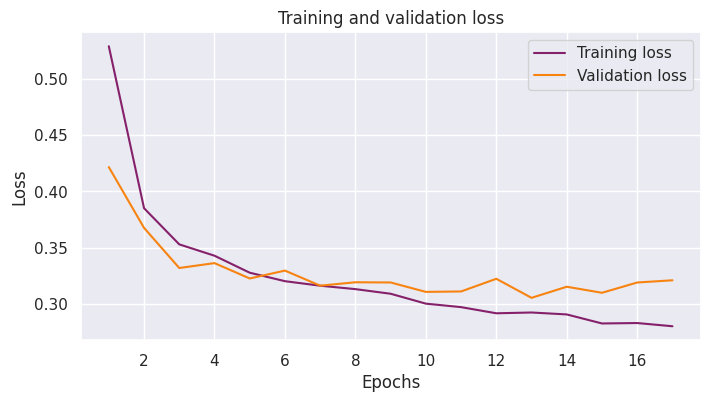

In [74]:
history_visualization(binary_classifier_4_history)

In [75]:
binary_classifier_4_loaded = keras.models.load_model(checkpoint_filepath_4)

In [76]:
loaded_scores_4 = binary_classifier_4_loaded.evaluate(X_test, y_test, verbose=1)
print_scores(loaded_scores_4)

44/44 [==============================] - 0s 2ms/step - loss: 0.3355 - binary_accuracy: 0.8635 - auc_3: 0.9257 - precision_3: 0.8235 - recall_3: 0.9253 - accuracy: 0.8635
Accuracy:  0.8635057210922241
AUC:  0.9256765246391296
Precision:  0.8235294222831726
Recall:  0.9252873659133911
Weighted Accuracy:  0.8635057210922241


44/44 [==============================] - 0s 2ms/step


<ipython-input-11-53c60886be05>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linewidth=.8, color = '#000')


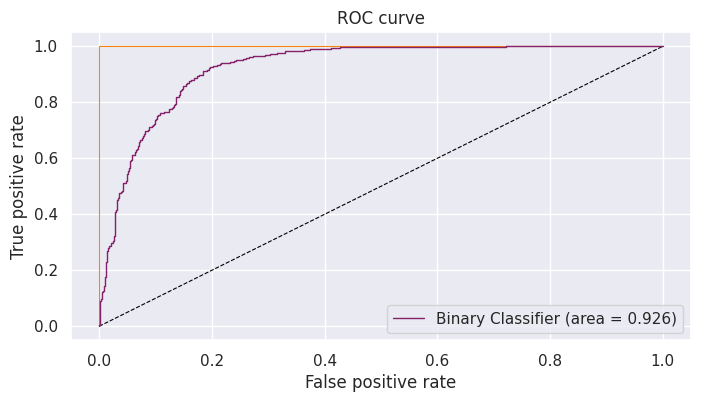

In [77]:
draw_roc_curve(binary_classifier_4_loaded, X_test, y_test)

44/44 [==============================] - 0s 2ms/step
[[558 138]
 [ 52 644]]


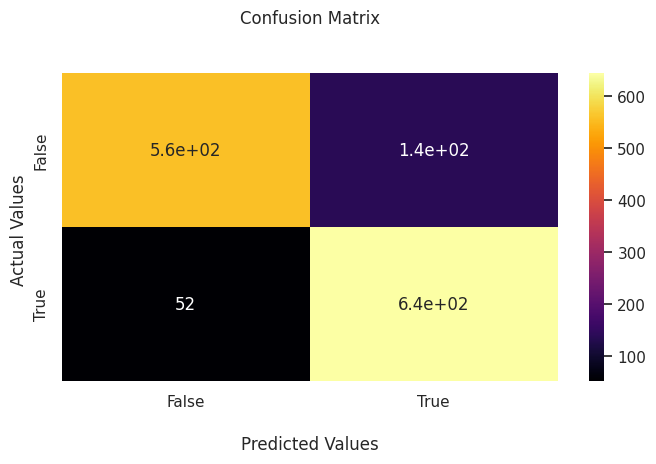

In [78]:
conf_matrix(binary_classifier_4_loaded, X_test, y_test, palette)